<a href="https://colab.research.google.com/github/Alexey504/CV_Rocket/blob/main/CV_Rocket_hw1_main_ALEXEY_MATVEEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: Сбор данных, автоматическая разметка и оценка качества (50 баллов)
В этом задании вы научитесь:
- загружать изображения из открытых датасетов;
- применять предобученные модели для автоматической разметки;
- оценивать качество разметки с помощью базовых метрик;
- сравнивать сходимость между результатами разных разметок.

Это важно, потому что автоматическая разметка помогает ускорять работу над CV-датасетами, особенно при построении пайплайнов активного обучения или semi-supervised подходов.


### Установим все необходимые зависимости:

In [1]:
!pip install -q roboflow ultralytics
!pip install -q inference-sdk
!pip install -q torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127

In [43]:
from typing import List, Tuple

In [8]:
import shutil

shutil.rmtree('People-Detection-1')

## Работа с данными

Начнем работу с датасетами из Roboflow. В этом домашнем задании расмотрим задачу детекции людей.

Для того чтобы скачать данные, необходимо зарегистрировать на Roboflow https://roboflow.com/ и использовать свой API-ключ.

API-ключ можно найти в личном кабинете в разделе Settings->API Keys

Используйте Private API Key

#### **Задание (2 балла)**:
Скачайте с Roboflow вот этот датасет https://universe.roboflow.com/leo-ueno/people-detection-o4rdr
Визуализируйте 6 случайных изображений


In [9]:
from roboflow import Roboflow
from google.colab import userdata


# TODO: Воспользуйтесь API-ключом, загрузите и визуализируйте датасет
# ---- Ваш код здесь ----
api_key = userdata.get('ROBOFLOWAPIKEY')
rf = Roboflow(api_key=api_key)
project = rf.workspace("leo-ueno").project("people-detection-o4rdr")
version = project.version(1)
dataset = version.download("yolov8")
# ---- Конец кода ----



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to People-Detection-1 in yolov8:: 100%|██████████| 2138/2138 [00:00<00:00, 2703.78it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Перед тем как применять автоматическую разметку или оценивать качество аннотаций, важно визуально ознакомиться с содержимым датасета.
Это помогает:
- понять, насколько разнообразны сцены;
- определить, есть ли шумные или пустые изображения;
- проверить, соответствуют ли изображения ожидаемому формату (цвет, размер, объекты).

## Визуализация изображений

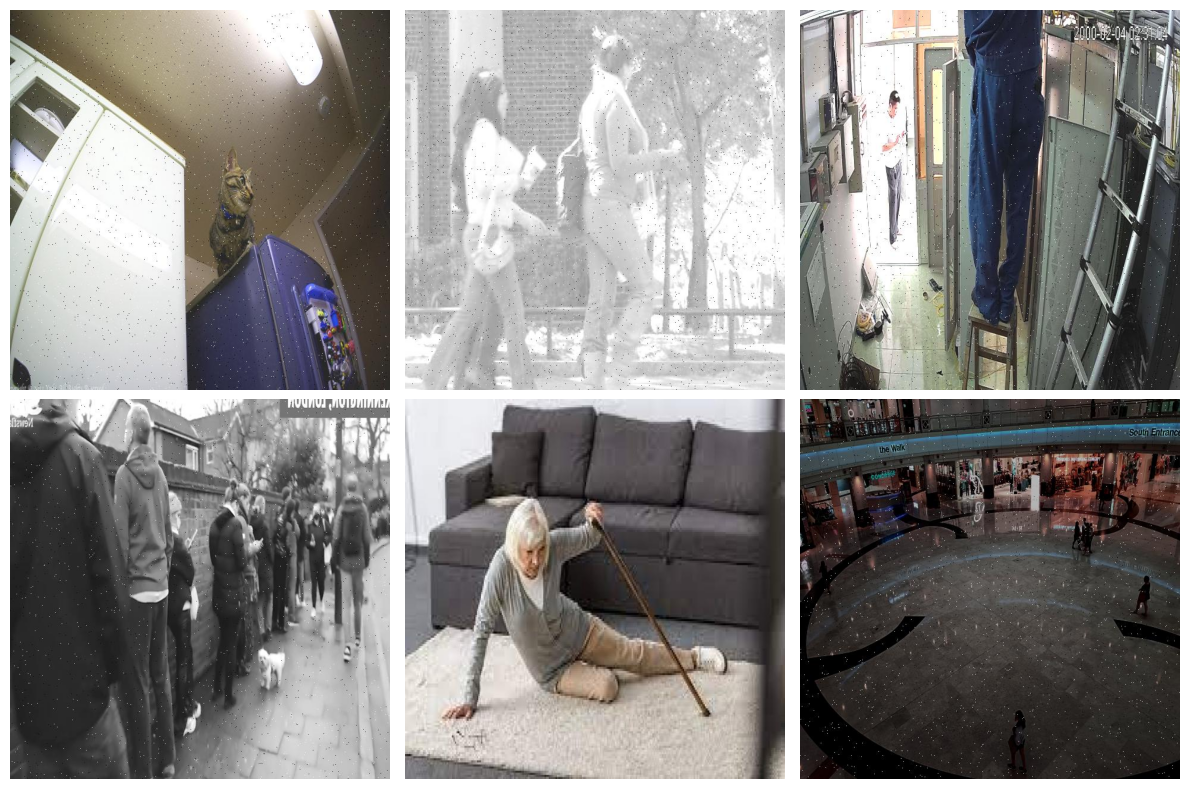

In [10]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

image_dir = "People-Detection-1/train/images"
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

random_images = random.sample(image_files, 6)

plt.figure(figsize=(12, 8))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Разметка данных

Для того, чтобы понять что такое разметка и как с ней работать, сымитируем процесс разметки с помщью моделей.


Выберите и примените 3 предобученные модели (YOLOv8n, YOLOv8m, Faster R-CNN) для автоматической разметки изображений. Сохраните или выведите bounding boxes только для класса person.

#### **Задание (10 баллов)**:
загрузите модели 2 модели YOLO и 1 Faster R-CNN и получите результат разметки

In [35]:
from ultralytics import YOLO
# ---- Ваш код здесь ----
# M1: YOLOv8n (на COCO)
model_yolo_n = YOLO('yolov8n.pt')
model_yolo_n.classes = [0]
# M2: YOLOv8m (на COCO)
model_yolo_m = YOLO('yolov8m.pt')
model_yolo_m.classes = [0]
# ---- Конец кода ----

In [15]:
import torchvision
import torchvision.transforms as T
import torch
from PIL import Image

# Загрузка модели
model_frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_frcnn.eval()

transform = T.ToTensor()

def run_frcnn(img_path):
  image = Image.open(img_path)
  image = transform(image)
  # ---- Ваш код здесь ----
  with torch.no_grad():
    output = model_frcnn([image])[0]
  # ---- Конец кода ----
    return output  # содержит .boxes, .labels, .scores


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
import os

# Путь к изображениям
image_dir = "People-Detection-1/train/images"
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')])
# Ограничьте количество изображения
image_paths = [os.path.join(image_dir, f) for f in image_files][:25]

# ---- Ваш код здесь ----
results_yolo_n = model_yolo_n(image_paths)
results_yolo_m = model_yolo_m(image_paths)
results_faster_rcnn = list(map(lambda image_path: run_frcnn(image_path), image_paths))
# ---- Конец кода ----


0: 640x640 1 car, 1 cat, 1 suitcase, 389.6ms
1: 640x640 (no detections), 389.6ms
2: 640x640 (no detections), 389.6ms
3: 640x640 (no detections), 389.6ms
4: 640x640 (no detections), 389.6ms
5: 640x640 1 bottle, 389.6ms
6: 640x640 1 bottle, 389.6ms
7: 640x640 1 bottle, 2 chairs, 389.6ms
8: 640x640 1 bottle, 389.6ms
9: 640x640 1 bottle, 1 chair, 389.6ms
10: 640x640 16 persons, 1 bottle, 2 wine glasss, 9 cups, 3 bowls, 1 dining table, 389.6ms
11: 640x640 16 persons, 2 wine glasss, 7 cups, 5 bowls, 1 dining table, 389.6ms
12: 640x640 13 persons, 2 bottles, 1 wine glass, 5 cups, 7 bowls, 1 dining table, 389.6ms
13: 640x640 12 persons, 1 wine glass, 6 cups, 2 bowls, 1 pizza, 1 dining table, 389.6ms
14: 640x640 15 persons, 4 wine glasss, 8 cups, 3 bowls, 1 dining table, 389.6ms
15: 640x640 (no detections), 389.6ms
16: 640x640 (no detections), 389.6ms
17: 640x640 1 suitcase, 1 teddy bear, 389.6ms
18: 640x640 1 chair, 1 teddy bear, 389.6ms
19: 640x640 1 teddy bear, 389.6ms
20: 640x640 1 suitcas

In [44]:
results_faster_rcnn

[{'boxes': tensor([[340.1224, 231.8832, 417.7986, 457.7831],
          [309.0071, 381.7103, 572.5827, 634.7425],
          [300.5114, 397.8500, 570.5829, 640.0000],
          [313.5000, 385.5519, 589.3652, 635.1904],
          [301.8761, 369.2372, 575.7385, 640.0000],
          [  0.0000,  88.0366, 323.2411, 628.5531],
          [339.7385, 217.0231, 416.3952, 450.3547],
          [  3.4980, 183.6549, 303.4231, 623.9286],
          [496.9150, 455.8280, 588.7188, 633.1897],
          [  1.7078, 229.6991,  46.6105, 310.9997],
          [  3.4575,   5.4564, 566.9872, 633.5997],
          [  0.0000,  89.2202, 320.9350, 629.0878],
          [ 10.9498, 198.7507, 301.3224, 632.1279],
          [308.9602, 399.5746, 576.8647, 632.5941],
          [ 44.4898, 169.4224, 102.8695, 217.0365],
          [ 12.3513, 221.2553,  68.8946, 304.5918]]),
  'labels': tensor([17, 82, 72, 73, 33, 82, 18, 70, 84, 84, 82, 72, 81, 62, 51, 84]),
  'scores': tensor([0.9493, 0.6082, 0.4360, 0.3367, 0.2398, 0.2392, 0.2

### Визуализируйте результаты разметки

Перед тем как оценивать результаты разметки, необходимо визуально оценить как выглядит разметка

#### Задание(2 баллов):
Визуализируйте результаты разметки Yolo и Faster R-CNN

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch

def plot_person_boxes_all_models(image_path, yolo_result=None, frcnn_result=None, rf_result=None, model_name=""):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # --- YOLOv8 результат ---
    if yolo_result is not None:
      # ---- Ваш код здесь ----

      boxes = yolo_result.boxes.xyxy[yolo_result.boxes.cls == 0]
      boxes = boxes.numpy()
      # classes = yolo_result.boxes.cls.numpy()
      for box in boxes:
        x1, y1, x2, y2 = box

        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False,
                             linewidth=2, color='blue')
        ax.add_patch(rect)
      # ---- Конец кода ----

    # --- Faster R-CNN результат ---
    if frcnn_result is not None:
      # ---- Ваш код здесь ----
      person_boxes = frcnn_result['boxes'][frcnn_result['labels'] == 1]
      for box in person_boxes:
        box = box.numpy()
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             fill=False, linewidth=2, color='red')
        ax.add_patch(rect)
      # ---- Конец кода ----
    plt.title(model_name)
    plt.axis('off')
    plt.show()

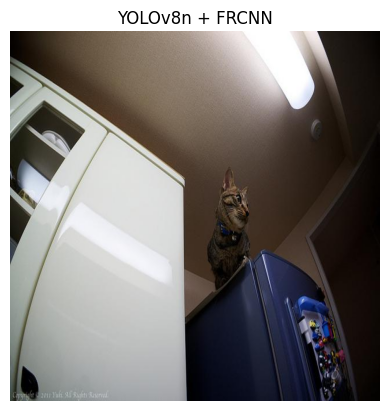

In [115]:
i = 0  # индекс изображения
plot_person_boxes_all_models(
    image_path=image_paths[i],
    yolo_result=results_yolo_n[i],
    frcnn_result=results_faster_rcnn[i],  # или None, если ты не используешь FRCNN
    model_name="YOLOv8n + FRCNN"
)

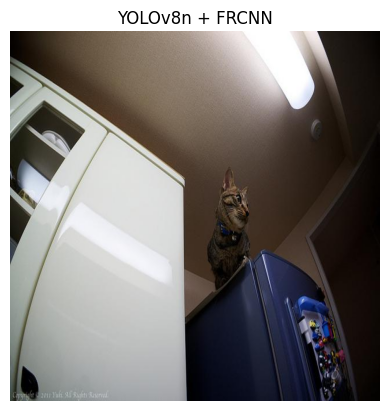

In [104]:
i = 0  # индекс изображения
plot_person_boxes_all_models(
    image_path=image_paths[i],
    yolo_result=results_yolo_m[i],
    frcnn_result=results_faster_rcnn[i],  # или None, если ты не используешь FRCNN
    model_name="YOLOv8n + FRCNN"
)

## Оценка результатов разметки

### Выделение результатов разметки

#### Задание(10 баллов):
Для всех результатов "разметки" выдели только ббоксы связанные с классом person

In [57]:
def extract_yolo_boxes(result) -> List[List[float]]:
    """
    Возвращает список bbox'ов класса 'person' (class_id = 0) из YOLOv8 результата.

    Parameters:
        result: объект результата модели YOLOv8 (ultralytics.engine.results.Results)

    Returns:
        List[List[float]]: список прямоугольников [x1, y1, x2, y2]
    """
    # ---- Ваш код здесь ----
    result = result.boxes.xyxy[result.boxes.cls == 0]

    # ---- Конец кода ----
    return result

In [59]:
def extract_frcnn_boxes(result, threshold=0.5):
      """
    Извлекает bbox'ы класса 'person' из результата Faster R-CNN при score >= threshold.

    Параметры:
        result (dict): результат модели Faster R-CNN с ключами 'boxes', 'labels', 'scores'.
        threshold (float): минимальный порог уверенности (по умолчанию 0.5).

    Возвращает:
        List[List[float]]: список bbox в формате [x1, y1, x2, y2], только для класса 'person' (label = 1).
    """
   # ---- Ваш код здесь ----
      person_conf = torch.logical_and(result['labels'] == 1, result['scores'] >= threshold)
      result = result['boxes'][person_conf]
    # ---- Конец кода ----
      return result

In [54]:
results_faster_rcnn[12]['scores'][results_faster_rcnn[12]['scores'] > 0.5]

tensor([0.9891, 0.9586, 0.9424, 0.9376, 0.9282, 0.9260, 0.9190, 0.9122, 0.9058, 0.8960, 0.8703, 0.8658, 0.8613, 0.8565, 0.8564, 0.8382, 0.8263, 0.8160, 0.7490, 0.7218, 0.7208, 0.7151, 0.6909, 0.6432, 0.5958, 0.5709, 0.5621, 0.5502, 0.5289, 0.5225])

In [170]:
results_faster_rcnn[0]['boxes'][torch.logical_and(results_faster_rcnn[0]['labels'] == 1, results_faster_rcnn[0]['scores'] > 0.5)]

tensor([], size=(0, 4))

In [60]:
boxes_yolo_n = [extract_yolo_boxes(r) for r in results_yolo_n]
boxes_yolo_m = [extract_yolo_boxes(r) for r in results_yolo_m]
boxes_faster_rcnn = [extract_frcnn_boxes(r) for r in results_faster_rcnn]

In [129]:
results_yolo_n[0].boxes.xyxy[results_yolo_n[0].boxes.cls == 0]


tensor([], size=(0, 4))

### Подсчет метрик разметки

In [62]:
boxes_faster_rcnn

[tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([], size=(0, 4)),
 tensor([[  2.5489, 262.2463,  82.2759, 631.3706],
         [490.0449, 201.4590, 639.6718, 634.0645],
         [447.5067, 158.4974, 554.5786, 431.0037],
         [ 35.1100, 241.7205, 192.3792, 602.8138],
         [364.9318,  88.9033, 452.0378, 293.5907],
         [284.5016,  87.8084, 348.8793, 207.6917],
         [210.6094,  39.6063, 262.7440, 152.5282],
         [192.8536, 115.3959, 260.1235, 264.4005],
         [364.1476,  22.3046, 409.7440, 132.6555],
         [143.8498, 203.2535, 234.3277, 452.3920],
         [379.0024, 205.4799, 451.8959, 404.3595],
         [449.5854, 239.4357, 544.9557, 539.2980],
         [211.3687, 197.4091, 275.8840, 329.4183],
         [106.5992, 151.4478, 168.7676, 367.7662],
         [ 99.2031, 177.97

#### Задание(10 баллов):
Посчитайте IoU метрику между ббоксами и оцените согласованность между разметками

In [202]:
def compute_iou(boxA, boxB) -> float:
    """
    Вычисляет IoU (Intersection over Union) между двумя прямоугольниками.

    Параметры:
        boxA (List[float]): координаты первого bbox [x1, y1, x2, y2]
        boxB (List[float]): координаты второго bbox [x1, y1, x2, y2]

    Возвращает:
        float: значение IoU от 0 до 1
    """
      # ---- Ваш код здесь ----
      # области пересечения
    # print(boxA, boxB)
    if not len(boxA) and not len(boxB):
      return 1.0
    elif not len(boxA) or not len(boxB):
      return 0.0
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # площадь пересечения
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # площади кадлого пу
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # подсчет iou
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # ---- Конец кода ----
    return iou

In [82]:
import numpy as np

In [201]:
def iou_agreement(boxes_a, boxes_b, iou_thresh=0.5) -> float:
    """
    Вычисляет долю bbox'ов из A, которые согласованы с bbox'ами из B по IoU >= порога.

    Параметры:
        boxes_a (List[List[float]]): список bbox модели A
        boxes_b (List[List[float]]): список bbox модели B
        iou_thresh (float): порог IoU для согласия (по умолчанию 0.5)

    Возвращает:
        float: доля согласованных bbox (от 0 до 1)
    """
    # ---- Ваш код здесь ----
    if not len(boxes_a) and not len(boxes_a):
      return 1.0

    matched = 0
    for box_a in boxes_a:
      for box_b in boxes_b:
        iou = compute_iou(box_a, box_b)
        if iou >= iou_thresh:
          matched += 1
          break
    iou_percent = matched / len(boxes_a)


    # ---- Конец кода ----
    return iou_percent

In [176]:

def mean_iou_agreement(all_a, all_b) -> float:
    """
    Вычисляет среднюю долю согласованных bbox по всему датасету.

    Параметры:
        all_a (List[List[List[float]]]): список bbox'ов по изображениям модели A
        all_b (List[List[List[float]]]): список bbox'ов по изображениям модели B

    Возвращает:
        float: среднее значение IoU согласия по изображениям
    """
    # ---- Ваш код здесь ----
    all_agr = []
    for bbox_a, bbox_b in zip(all_a, all_b):
      agr = iou_agreement(bbox_a, bbox_b)
      all_agr.append(agr)
    mean_iou = np.mean(all_agr)
    # ---- Конец кода ----
    return mean_iou

In [179]:
agreement_1_2 = mean_iou_agreement(boxes_yolo_n, boxes_yolo_m)
agreement_1_3 = mean_iou_agreement(boxes_yolo_n, boxes_faster_rcnn)
agreement_2_3 = mean_iou_agreement(boxes_yolo_m, boxes_faster_rcnn)

print(f"Сходимость M1 vs M2: {agreement_1_2:.2f}")
print(f"Сходимость M1 vs M3: {agreement_1_3:.2f}")
print(f"Сходимость M2 vs M3: {agreement_2_3:.2f}")

Сходимость M1 vs M2: 0.99
Сходимость M1 vs M3: 0.99
Сходимость M2 vs M3: 0.93


#### Задание(10 баллов):
Проанализируйте метрики сходимости precision, recall, f1 и Cohen’s Kappa.

In [208]:
def match_predictions(pred_boxes, ref_boxes, iou_thresh=0.5) -> Tuple[int, int, int]:
    """
    Сопоставляет предсказанные bbox с эталонными и возвращает TP, FP, FN.

    Параметры:
        pred_boxes (List[List[float]]): список bbox от модели
        ref_boxes (List[List[float]]): список bbox из эталона (GT или другой модели)
        iou_thresh (float): порог для совпадения IoU

    Возвращает:
        Tuple[int, int, int]: TP, FP, FN
    """
    # ---- Ваш код здесь ----
    matched_ref = set()
    tp = 0

    for pred in pred_boxes:
        best_iou = 0
        best_ref_idx = -1
        for idx, ref in enumerate(ref_boxes):
            if idx in matched_ref:
                continue
            current_iou = compute_iou(pred, ref)
            if current_iou > best_iou:
                best_iou = current_iou
                best_ref_idx = idx
        if best_iou >= iou_thresh:
            tp += 1
            matched_ref.add(best_ref_idx)

    fp = len(pred_boxes) - tp
    fn = len(ref_boxes) - len(matched_ref)

    # ---- Конец кода ----
    return tp, fp, fn

In [88]:
def precision_recall_f1(tp, fp, fn) -> Tuple[float, float, float]:
    """
    Вычисляет precision, recall и F1 по TP, FP, FN.

    Параметры:
        tp (int): true positives
        fp (int): false positives
        fn (int): false negatives

    Возвращает:
        Tuple[float, float, float]: precision, recall, f1
    """
    # ---- Ваш код здесь ----
    # Вычисляем precision (точность)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # Вычисляем recall (полноту)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # Вычисляем F1-score (гармоническое среднее precision и recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    # ---- Конец кода ----
    return precision, recall, f1

In [161]:
from sklearn.metrics import cohen_kappa_score

def compute_kappa(boxes_a, boxes_b) -> float:
    """
    Вычисляет метрику Cohen’s Kappa для двух списков боксов на уровне изображения.

    Параметры:
        boxes_a (List[List[List[float]]]): bbox'ы модели A
        boxes_b (List[List[List[float]]]): bbox'ы модели B

    Возвращает:
        float: значение Kappa от -1 до 1
    """
    # ---- Ваш код здесь ----
    # списки меток
    max_len = max(len(boxes_a), len(boxes_b))
    labels_a = np.zeros(max_len, dtype=int)
    labels_b = np.zeros(max_len, dtype=int)

    # Сопоставляем боксы между двумя моделями
    matched_a = set()
    matched_b = set()

    # Строим матрицу IoU
    iou_matrix = np.zeros((len(boxes_a), len(boxes_b)))
    for i, box_a in enumerate(boxes_a):
        for j, box_b in enumerate(boxes_b):
            iou_matrix[i, j] = compute_iou(box_a, box_b)

    # Жадное сопоставление (greedy matching)
    while True:
        max_iou = np.max(iou_matrix)
        if max_iou < iou_thresh:
            break

        i, j = np.unravel_index(np.argmax(iou_matrix), iou_matrix.shape)
        matched_a.add(i)
        matched_b.add(j)

        # Обнуляем строку и столбец, чтобы исключить их из дальнейшего сопоставления
        iou_matrix[i, :] = 0
        iou_matrix[:, j] = 0

    # Проставляем метки для сопоставленных боксов
    for i in range(len(boxes_a)):
        if i in matched_a:
            labels_a[i] = 1

    for j in range(len(boxes_b)):
        if j in matched_b:
            # Учитываем, что у labels_b может быть другая длина
            if j < len(labels_b):
                labels_b[j] = 1

    # Выравниваем длины (дополняем нулями)
    if len(labels_a) < max_len:
        labels_a = np.pad(labels_a, (0, max_len - len(labels_a)), 'constant')
    if len(labels_b) < max_len:
        labels_b = np.pad(labels_b, (0, max_len - len(labels_b)), 'constant')

    # Вычисляем Cohen's Kappa
    kappa = cohen_kappa_score(labels_a, labels_b)
    # ---- Конец кода ----
    return cohen_kappa

In [210]:
def compare_models(pred_a, pred_b, iou_thresh=0.5)->Tuple[float, float, float, float]:
    """
    Сравнивает две модели по IoU: TP, FP, FN, метрики и Kappa.

    Параметры:
        pred_a (List[List[List[float]]]): bbox'ы модели A
        pred_b (List[List[List[float]]]): bbox'ы модели B
        iou_thresh (float): порог IoU

    Возвращает:
        Tuple[float, float, float, float]: precision, recall, F1, kappa
    """
    # ---- Ваш код здесь ----
    # print(pred_a)
    tp, fp, fn = match_predictions(pred_a, pred_b, iou_thresh)
    precision, recall, f1 = precision_recall_f1(tp, fp, fn)

    kappa = compute_kappa(pred_a, pred_b)

    # ---- Конец кода ----
    return precision, recall, f1, kappa

#### Задание(1 балла):
На основе результатов метрик напишите вывод о том, значат эти метрики и какие можно сделать выводы о разметке.

In [211]:
metrics_1_2 = compare_models(boxes_yolo_n, boxes_yolo_m)
metrics_1_3 = compare_models(boxes_yolo_n, boxes_faster_rcnn)
metrics_2_3 = compare_models(boxes_yolo_m, boxes_faster_rcnn)

import pandas as pd
df_cmp = pd.DataFrame({
    "Pair": ["M1 vs M2", "M1 vs M3", "M2 vs M3"],
    "Precision": [metrics_1_2[0], metrics_1_3[0], metrics_2_3[0]],
    "Recall": [metrics_1_2[1], metrics_1_3[1], metrics_2_3[1]],
    "F1 Score": [metrics_1_2[2], metrics_1_3[2], metrics_2_3[2]],
    "Cohen’s Kappa": [metrics_1_2[3], metrics_1_3[3], metrics_2_3[3]]
})

df_cmp.style.format({"Precision": "{:.2%}", "Recall": "{:.2%}", "F1 Score": "{:.2%}", "Cohen’s Kappa": "{:.2f}"})

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

Вывод: # ---- Ваш комментарий здесь ----

## Визуализация метрик
Для того чтобы проанализировать метрики, визуализируем heatmap метрик

tensor([4.8859e-02, 2.5314e+02, 9.6955e+01, 6.3934e+02]) tensor([3.6931e-01, 2.5316e+02, 8.9738e+01, 6.3916e+02])
tensor([448.9469, 158.5764, 553.9321, 417.6941]) tensor([3.6931e-01, 2.5316e+02, 8.9738e+01, 6.3916e+02])
tensor([448.9469, 158.5764, 553.9321, 417.6941]) tensor([441.8968, 283.6377, 537.4356, 547.2076])
tensor([448.9469, 158.5764, 553.9321, 417.6941]) tensor([159.2760, 201.5560, 213.2905, 366.6837])
tensor([448.9469, 158.5764, 553.9321, 417.6941]) tensor([279.5737,  86.4484, 347.0424, 201.6216])
tensor([448.9469, 158.5764, 553.9321, 417.6941]) tensor([104.5743, 150.0632, 211.8237, 466.4540])
tensor([448.9469, 158.5764, 553.9321, 417.6941]) tensor([ 42.3549, 229.7322, 151.3879, 629.7473])
tensor([448.9469, 158.5764, 553.9321, 417.6941]) tensor([371.1241,  86.0890, 457.5899, 307.5752])
tensor([448.9469, 158.5764, 553.9321, 417.6941]) tensor([492.0926, 202.6788, 639.7068, 639.0952])
tensor([448.9469, 158.5764, 553.9321, 417.6941]) tensor([447.9308, 157.8424, 551.2338, 428.754

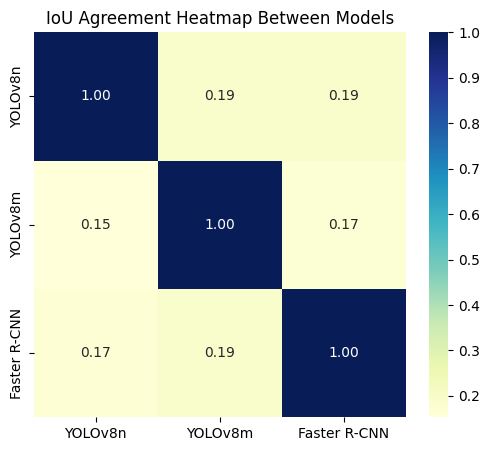

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# IoU-покрытие для одной пары моделей
def iou_agreement(boxes_a, boxes_b, iou_thresh=0.5):
    matched = 0
    for a in boxes_a:
        if any(compute_iou(a, b) >= iou_thresh for b in boxes_b):
            matched += 1
    return matched / max(1, len(boxes_a))

# Считаем среднюю сходимость по датасету
def iou_matrix(all_a, all_b):
    scores = []
    for a_boxes, b_boxes in zip(all_a, all_b):
        scores.append(iou_agreement(a_boxes, b_boxes))
    return np.mean(scores)

# Построим матрицу
iou_values = np.array([
    [1.0,
     iou_matrix(boxes_yolo_n, boxes_yolo_m),
     iou_matrix(boxes_yolo_n, boxes_faster_rcnn)],
    [iou_matrix(boxes_yolo_m, boxes_yolo_n),
     1.0,
     iou_matrix(boxes_yolo_m, boxes_faster_rcnn)],
    [iou_matrix(boxes_faster_rcnn, boxes_yolo_n),
     iou_matrix(boxes_faster_rcnn, boxes_yolo_m),
     1.0]
])

labels = ["YOLOv8n", "YOLOv8m", "Faster R-CNN"]
plt.figure(figsize=(6, 5))
sns.heatmap(iou_values, xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("IoU Agreement Heatmap Between Models")
plt.show()

In [197]:
# Считаем разницу между количеством боксов у моделей
disagreement_scores = []
for i, (b1, b2, b3) in enumerate(zip(boxes_yolo_n, boxes_yolo_m, boxes_faster_rcnn)):
    n1, n2, n3 = len(b1), len(b2), len(b3)
    score = max(abs(n1 - n2), abs(n1 - n3), abs(n2 - n3))
    disagreement_scores.append((i, score))

# Сортируем по убыванию разногласий
disagreement_scores.sort(key=lambda x: x[1], reverse=True)

# Выводим топ-5 изображений с наибольшими расхождениями
print("Наибольшие расхождения в количестве bbox:")
for i, score in disagreement_scores[:5]:
    print(f"{i}: {image_paths[i]} — различие: {score} bbox")

Наибольшие расхождения в количестве bbox:
13: People-Detection-1/train/images/000000018380_jpg.rf.c5952d77fc9cf07e06f0d85b9236423d.jpg — различие: 7 bbox
12: People-Detection-1/train/images/000000018380_jpg.rf.a8fe2e44edaf4a352fb4b31d46ab1fa9.jpg — различие: 4 bbox
10: People-Detection-1/train/images/000000018380_jpg.rf.1f2816b8a7ae8757062f9801f3fa3638.jpg — различие: 2 bbox
11: People-Detection-1/train/images/000000018380_jpg.rf.32d1d4e279938c65525968ee700d6c55.jpg — различие: 2 bbox
14: People-Detection-1/train/images/000000018380_jpg.rf.f9de937557be5b24955fd1ff107b67f0.jpg — различие: 2 bbox


## Создание финального датасета

Теперь финальная часть - создание датасета.
В реальной практике, когда происходит перекрестная разметка несколькими разметчиками, для того чтобы взять эталлонный gt можно использовать концепцию пересечения как минимум 2 моделей. То есть мы считаем что лейбл "истинный", если есть пересечение разметки

#### **Задание(5 балла)**:
Напишите код, для того чтобы создать финальный датасет. Финальный датасет содержит лейблы, если есть пересечение минимум 2 моделей

In [ ]:
def is_supported_by_others(box, others, iou_thresh=0.5) -> bool:
    """
    Проверяет, был ли bbox поддержан как минимум двумя другими источниками (моделями).

    Параметры:
        box (List[float]): текущий bbox в формате [x1, y1, x2, y2]
        others (List[List[List[float]]]): список bbox'ов от других моделей
        iou_thresh (float): порог IoU для согласия (по умолчанию 0.5)

    Возвращает:
        bool: True, если bbox подтверждён ≥ 2 другими источниками
    """
    # ---- Ваш код здесь ----

    # ---- Конец кода ----
    return result

# Финальный датасет: bbox'ы, подтверждённые ≥2 моделями
final_dataset = []

for b1, b2, b3 in zip(boxes_yolo_n, boxes_yolo_m, boxes_faster_rcnn):
    all_boxes = b1 + b2 + b3
    # Убираем повторы
    unique_boxes = []
    for box in all_boxes:
        if not any(compute_iou(box, u) > 0.95 for u in unique_boxes):
            unique_boxes.append(box)

    # Фильтрация: оставляем только bbox с подтверждением
    accepted = []
    for box in unique_boxes:
        if is_supported_by_others(box, [b1, b2, b3]):
            accepted.append(box)
    final_dataset.append(accepted)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_final_boxes(image_paths, final_dataset, n=5):
    plt.figure(figsize=(15, 3 * n))
    for i in range(n):
        img = Image.open(image_paths[i])
        boxes = final_dataset[i]

        ax = plt.subplot(n, 1, i + 1)
        ax.imshow(img)
        for box in boxes:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, "person", color='lime', fontsize=10)
        ax.set_title(f"Image {i+1}: {os.path.basename(image_paths[i])}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_final_boxes(image_paths, final_dataset, n=5)  # можно изменить n